## TEMPORARY HELPING FUNCTIONS 

A temporary Jupyter Notebook for fast writing and testing some useful function

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

UniRef90_P43582: MAQSKSNPPQVPSGWKAVFDDEYQTWYYVDLSTNSSQWEPPRGTTWPRPKGPPPGVNNEKSSRQQADQAPPPYSSQSTPQVQAGAQAQQPRYYQPQQPQYPQYPQQQRYYPQQAPMPAAAPQQAYYGTAPSTSKGSGHGGAMMGGLLGVGAGLLGGAMLEHAFDDHNYDGPDTVVVENNYYGDDAGGSDGGFDDAGGFDGGFDDGFDGSDF

UniRef90_J8Q8J2: MAQSKSNPPQVPSGWKAVFDDEYQTWFYVDLSTNNSQWEPPKGASFPRPKGPPPAANNEKTSRQQGDQAPPPYSAQSRTQPQPQAQQAQQGRYYQPQQPQYPQQPQQQSYYPQQVPMAAAAAPQQGYYGATPTAAKSSGRSGAMMGGLLGVGAGLLGGAMLEHAFDDHSHGGPGPVVENNYYGDDNGGGFGGPFDGGFDGEFDGGFDGGDF

UniRef90_J5RH20: MAQSKGNPPQVPSGWKAVFDDEYQTWFYVNLSTNSSQWEPPKGTTWPRPKGPPPGVNNEKSSRQEVDQAPPPYSSQSRAQPQAPAQQTRYYQPQQSQYPQQPQQQRYYQQQAPMAAAAPQQAYYGTTPSAAKSSGHGGAMMGGLLGVGAGLLGGAMLEHAFDDHDNYDQPDNVVVENNYYGDDGGFDGGFDGGFDGGDF

Index of sequence with length greater than 1000:
[]


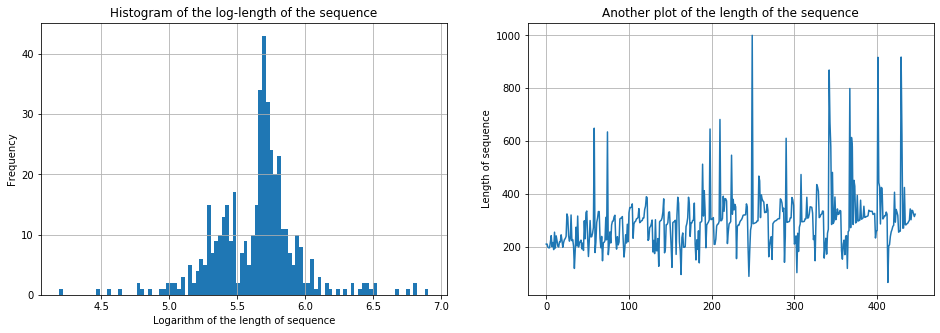

In [13]:
"""
Take a path of a fasta file and return a dict {id: sequence} (tuned on the example of uniref90)
"""
def fasta_to_dict(path): 
    with open(path, 'r') as file:
        lines = [line for line in file]
   
    # Get two separate list
    ids = []
    chain = []
    temp=[]
    for n, l in enumerate(lines):
        if l[0] == '>':
            sentence = l.split()[0]
            ids.append(sentence[1:]) # We take only the first part as identifier
            if n>1:
                chain.append(temp)
                temp = []
        else:
            temp.append(l[:-1]) # We remove the '\n' at the end
    chain.append(temp)
    # Get a dictionary
    dict_fasta = {key: value for key, value in zip(ids, chain)}
    for key in dict_fasta:
        temp = ''
        n = len(dict_fasta[key])
        for i in range(n):
            temp += dict_fasta[key][i]
        dict_fasta[key] = temp

    return dict_fasta


"""
Example: we use data\\blast_uniref90_reduced.fasta as input
"""
# Get the dictionary
my_result = fasta_to_dict(path = 'data\\blast_uniref90_reduced.fasta')
# Print some lines
for n, key in enumerate(my_result.keys()):
    print('{}: {}'.format(key, my_result[key]), end='\n\n')
    if n >= 2:
        break
# Get the lenght of the sequences
length = [len(my_result[key]) for key in my_result]
# Get index of sequence with length greater than l
l = 1000
print('Index of sequence with length greater than {}:\n{}'.format(l, list(np.where([np.array(length) > l])[1])))
# Display distribution
fig, ax = plt.subplots(1, 2, figsize=(16, 5))
ax[0].hist(np.log(length), bins=100)
ax[0].grid()
ax[0].set_title('Histogram of the log-length of the sequence')
ax[0].set_ylabel('Frequency')
ax[0].set_xlabel('Logarithm of the length of sequence')
ax[1].plot(length)
ax[1].grid()
ax[1].set_title('Another plot of the length of the sequence')
ax[1].set_ylabel('Length of sequence')
plt.show()

In [5]:
"""
From a dict of id: sequence (see fasta_to_dict function) get a pandas dataframe from allignment
"""
def dict_to_df(my_dict):
    # Init variables
    max_length = np.max([len(my_dict[key]) for key in my_dict])
    df = pd.DataFrame()

    # Insert key: values
    for key in my_dict:
        # Split the value in single char
        value = [char for char in my_dict[key]]
        # Insert None until max_length is reached
        for i in range(len(value), max_length):
            value.append(None)
        df[key] = value
        
    # Return the transpose
    df = df.transpose()
    return df
    
df = dict_to_df(my_dict=my_result)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,11096,11097,11098,11099,11100,11101,11102,11103,11104,11105
UniRef90_P43582,M,A,Q,S,K,S,N,P,P,Q,...,None,None,None,None,None,None,None,None,None,None
UniRef90_J8Q8J2,M,A,Q,S,K,S,N,P,P,Q,...,None,None,None,None,None,None,None,None,None,None
UniRef90_J5RH20,M,A,Q,S,K,G,N,P,P,Q,...,None,None,None,None,None,None,None,None,None,None
UniRef90_A0A0L8RJY2,M,G,Q,S,K,S,N,P,P,Q,...,None,None,None,None,None,None,None,None,None,None
UniRef90_A0A212M9M4,M,P,Q,S,R,D,N,A,P,D,...,None,None,None,None,None,None,None,None,None,None


In [6]:
#best_len = [df.iloc[:, i].value_counts() for i in range(df.shape[1])]
best_len = []
for i in range(df.shape[1]):
    if i%2000 == 0:
        print('Progress: {}/{}'.format(i, df.shape[1]))
    # For each position gives the maximum number of equal occurrences
    best_len.append(df.iloc[:, i].value_counts()[0])
print('Done!')

Progress: 0/11106
Progress: 2000/11106
Progress: 4000/11106
Progress: 6000/11106
Progress: 8000/11106
Progress: 10000/11106


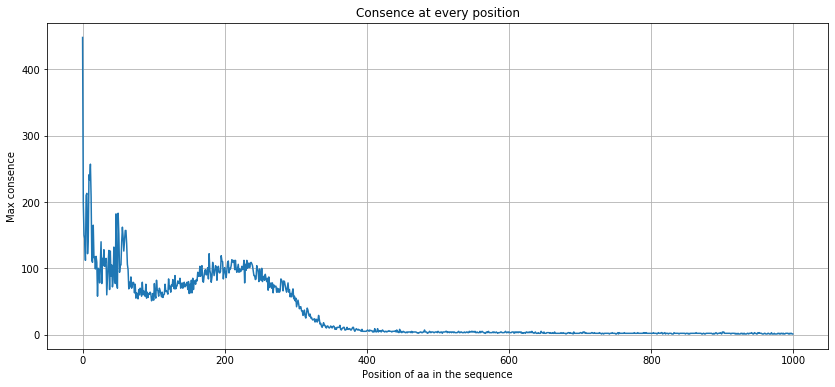

In [7]:
plt.figure(figsize=(14, 6))
plt.plot(best_len[0:1000])
plt.title('Consence at every position')
plt.ylabel('Max consence')
plt.xlabel('Position of aa in the sequence')
plt.grid()
plt.show()
#MAQSKSNPPQVPSGWKAVFDDEYQTWYYVDLSTNSSQWEPPRGTTWPRPKGPPPGVNNEKSSRQQADQAPPPYSSQSTPQVQAGAQAQQPRYYQPQQPQYPQYPQQQRYYPQQAPMPAAAPQQAYYGTAPSTSKGSGHGGAMMGGLLGVGAGLLGGAMLEHAFDDHNYDGPDTVVVENNYYGDDAGGSDGGFDDAGGFDGGFDDGFDGSDF

## HMMER Functions

In [9]:
"""
Check if there are proteins in the positive test set for HMM that are also in the training set ('the blast result used 
for the MSA and for the building of the HMM'). AKA: Check if there are proteins that are in both the training and the test set.
"""

# Get the 'training set' and the 'test set'
training_prot = fasta_to_dict(path = 'data\\blast_uniref90.fasta')
test_prot = fasta_to_dict(path = 'data\\positive_pfam_human_proteins.fasta')

# Get the the training and the test sequences
train_seq, test_seq = set(training_prot.values()), set(test_prot.values())

# Check if there is any sequence in test that is also in train
proteins_found = set()              # Here we insert any proteins found in both the sets
n = 0                               # Counter of proteins found in both
for seq in test_seq:
    if seq in train_seq:
        proteins_found.append(seq)  # If we found a double we insert in a list
        n += 1                      # Increment the counter 
        print('A protein in the test set has been found also in the test set: {}'.format(seq))

# Print the results
if n == 0:
    print('No proteins found in both training and test set!')
else:
    print('{} have been found in both training and test set.'.format(n))

No proteins found in both training and test set!
